# BBC News Classification
### By: Kyle Newman 

## Introduction

**Objective**


The goal of this project is to classify news articles that have not been seen before. The competition is scored based off of accuracy. There are 2225 articles with 5 different article classification categories. The training data conists of 1490 articles and the test (submission) data consists of 735 articles. 

### Important Information

It also important to note that because of the sheer size of this notebook, I will be creating a **reproducible workflow** using python modules within a virtual environment that will be available on github. I have also added detailed **explanations** of some of the basic concepts needed in a separate ipynb file. If you are unfamiliar with Natural Language Processing, vectorization, hyperparameter optimization, cross validation, or common machine learning algorithms, I'd highly recommend reading through the other notebook first. 

Also, there were limitations experienced due to a lack of resources. I could not create highly complex pipelines because hyperparameter tuning on these pipelines were taking more than 24 hours so I had to simplify them. In future projects I will be utilizing more current techniques such as Glove for word embedding instead of TFIDF. I will also hope to have access to stronger computing resources than just a laptop. 

### Installation of Dependenices

In [141]:
!pip install opendatasets # for downloading dataset into notenook with Kaggle API key
!pip install NLTK #installing NLTK and packages needed for preprocessing

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [72]:
import opendatasets as od
import pandas as pd
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize 
import matplotlib.pyplot as plt 
import seaborn as sns
from nltk.corpus import stopwords
# from nltk.stem import PorterStemmer
from nltk import FreqDist
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet as wn
import re
import string
import math
from matplotlib import gridspec
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF
import sklearn.metrics as metrics
import numpy as np
from sklearn.metrics import accuracy_score
import random
import time

In [ ]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


True

## Loading/Splitting Data

I am using the opendatasets library to load the dataset. Storing an API key and loading directly into the notebook is much more memory and time efficient than downloading directly to the disk.
The steps to generate an API Key on Kaggle:
1. Create account or sign in  
2. Click icon with profile photo
3. Select "your profile" from dropdown 
4. Click on account tab
5. Press generate New API token


In [ ]:
od.download("https://www.kaggle.com/competitions/learn-ai-bbc/data")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: kylenewman
Your Kaggle Key: ··········


100%|██████████| 1.85M/1.85M [00:00<00:00, 113MB/s]


Extracting archive ./learn-ai-bbc/learn-ai-bbc.zip to ./learn-ai-bbc


In [ ]:
submission_data = pd.read_csv('/content/learn-ai-bbc/BBC News Test.csv', low_memory = False) 
train =  pd.read_csv('/content/learn-ai-bbc/BBC News Train.csv', low_memory = False) #set to train and test model (will be split 80/20)
sample = pd.read_csv("/content/learn-ai-bbc/BBC News Sample Solution.csv", low_memory = False) 

In [ ]:
df = train.sample(frac=1, random_state = 342).reset_index(drop=True) #randomizing sample data
train_set = df[0:int(.8*len(df)+1)].reset_index(drop=True) # 80:20 train-test split
test_set = df[int(.8*len(df)+1):-1].reset_index(drop=True) 

In [ ]:
train_eda = train_set.copy(deep = True) #copy for EDA
train_model = train_set.copy(deep = True) #copy for modeling

In [ ]:
train_eda.head()

,ArticleId,Text,Category
0,290,sydney to host north v south game sydney will ...,sport
1,1037,vera drake leads uk oscar hopes mike leigh s f...,entertainment
2,500,argentina closes $102.6bn debt swap argentina ...,business
3,458,podcasts mark rise of diy radio an apple ipod ...,tech
4,175,mps to debate euthanasia laws mps are prepar...,politics


In [ ]:
sample.head() #sample solution 

,ArticleId,Category
0,1018,sport
1,1319,tech
2,1138,business
3,459,entertainment
4,1020,politics


We can see from above that our goal is to classify the article to the correct catgeory. 

# Exploratory Data Analysis

In [ ]:
submission_data.head() #set for submission to be graded on (metric for submission is accuracy)

NameError: ignored

In [11]:
train_set.head() #training set

,ArticleId,Text,Category
0,290,sydney to host north v south game sydney will ...,sport
1,1037,vera drake leads uk oscar hopes mike leigh s f...,entertainment
2,500,argentina closes $102.6bn debt swap argentina ...,business
3,458,podcasts mark rise of diy radio an apple ipod ...,tech
4,175,mps to debate euthanasia laws mps are prepar...,politics


In [12]:
print(train_set['Category'].unique()) # 5 different classes

['sport' 'entertainment' 'business' 'tech' 'politics']


In [13]:
print(train_set.info()) # no null values, which allows us to proceed to data cleaning

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1193 entries, 0 to 1192
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   ArticleId  1193 non-null   int64 
 1   Text       1193 non-null   object
 2   Category   1193 non-null   object
dtypes: int64(1), object(2)
memory usage: 28.1+ KB
None


In [ ]:
print(train_set["Text"][100]) #sample output (showing lack of structure)

In [15]:
print(train_set.describe()) #basic data output (large range)

         ArticleId
count  1193.000000
mean   1115.712490
std     638.915972
min       2.000000
25%     559.000000
50%    1100.000000
75%    1680.000000
max    2224.000000


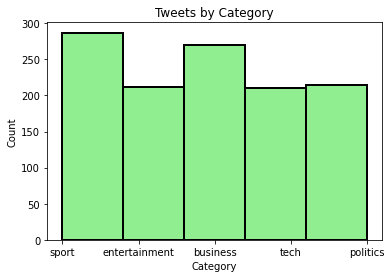

In [16]:
fig, ax = plt.subplots()
plt.style.use('default')
ax.hist(train_set['Category'], color = "lightgreen", ec = 'black',bins =5, lw=2)
ax.set_xlabel('Category')
ax.set_ylabel('Count')
plt.title("Tweets by Category")
plt.show()

There appears to be a slight class imbalance. This should not significantly affect our final metrics so we will not worry about stratified sampling.

In [17]:
train_set['Number_of_Words'] = train_set['Text'].str.split().str.len() #splitting set to get number of words per categeory

[Text(0.5, 1.0, 'Violin Plot of Word Counts')]

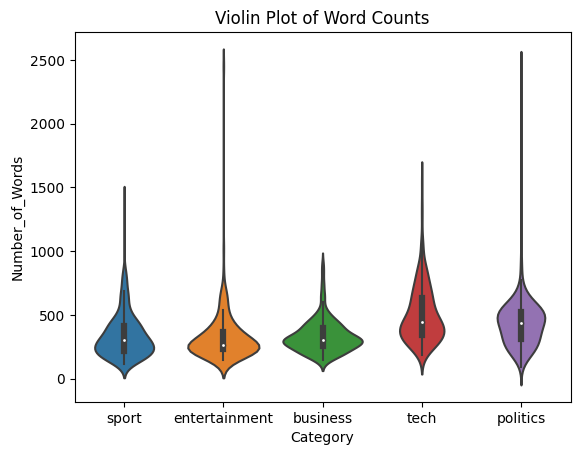

In [19]:
sns.violinplot(x="Category", y="Number_of_Words", data=train_set).set(title = "Violin Plot of Word Counts")

It appears that tech and politics have a wider density at higher word counts than the other three categories. We can also see that entertainment and politics have the mot significant outliers. Violin plots are a combination of box plots and kernel density plots, which use kernel density estimation. I won't go into to too much detail about kernal density estimation, but an application of it for marginal densities can be used to improve the accuracy of Naive Bayes Classifiers (which I will be implementing later). 

### Tokenization

In [20]:
for i in range(len(train_eda['Text'])):
  train_eda['Text'][i] = word_tokenize(train_eda['Text'][i])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


I tokenized the tweets above so it can be processed by the model and so more EDA can be performed. 

### Removing Punctuation



In [21]:
for i in range(len(train_eda)):
    train_eda['Text'][i] = [word for word in train_eda['Text'][i] if word not in string.punctuation]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


### Filtering Stop Words

In [22]:
stop_words = set(stopwords.words("english"))

In [23]:
for i in range(len(train_eda)):
    train_eda['Text'][i] = [word for word in train_eda['Text'][i] if word.casefold() not in stop_words]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [24]:
print(train_eda['Text'][100])

['mallon', 'wades', 'ne', 'vote', 'battle', 'middlesbrough', 'mayor', 'ray', 'mallon', 'drafted', 'boost', 'yes', 'campaign', 'north', 'east', 'assembly', 'referendum', 'enters', 'final', 'week', 'former', 'police', 'chief', 'dubbed', 'robocop', 'zero', 'tolerance', 'style', 'clashed', 'thursday', 'sunderland', 'campaigner', 'neil', 'herron', 'mr', 'mallon', 'said', 'assembly', 'would', 'give', 'local', 'people', 'say', 'key', 'issues', 'transport', 'crime', 'mr', 'herron', 'said', 'north', 'east', 'people', 'want', 'need', 'assembly', 'pair', 'met', 'platform', 'sunderland', 'station', 'mr', 'mallon', 'toured', 'region', 'highlighting', 'claimed', 'improvements', 'transport', 'area', 'gets', 'assembly', 'mr', 'herron', 'gained', 'fame', 'one', 'sunderland', 'metric', 'martyrs', 'running', 'campaign', 'alongside', 'official', 'north', 'east', 'says', 'campaign', 'said', 'convinced', 'mr', 'mallon', 'arguments', 'reality', 'going', 'deliver', 'said', 'labour', 'two-and-a-half', 'years',

I added the casefold argument since stopwords do not account for both upper and lower case letters. As can be seen from the otuputs, words such as 'a' and 'in' were removed.  

### Lemmatization
Since the context of words is important for the classification of tweets, we will be lemmatizing instead of stemming. 


In [25]:
lemmatizer = WordNetLemmatizer()

In [26]:
print(train_eda['Text'][100])

['mallon', 'wades', 'ne', 'vote', 'battle', 'middlesbrough', 'mayor', 'ray', 'mallon', 'drafted', 'boost', 'yes', 'campaign', 'north', 'east', 'assembly', 'referendum', 'enters', 'final', 'week', 'former', 'police', 'chief', 'dubbed', 'robocop', 'zero', 'tolerance', 'style', 'clashed', 'thursday', 'sunderland', 'campaigner', 'neil', 'herron', 'mr', 'mallon', 'said', 'assembly', 'would', 'give', 'local', 'people', 'say', 'key', 'issues', 'transport', 'crime', 'mr', 'herron', 'said', 'north', 'east', 'people', 'want', 'need', 'assembly', 'pair', 'met', 'platform', 'sunderland', 'station', 'mr', 'mallon', 'toured', 'region', 'highlighting', 'claimed', 'improvements', 'transport', 'area', 'gets', 'assembly', 'mr', 'herron', 'gained', 'fame', 'one', 'sunderland', 'metric', 'martyrs', 'running', 'campaign', 'alongside', 'official', 'north', 'east', 'says', 'campaign', 'said', 'convinced', 'mr', 'mallon', 'arguments', 'reality', 'going', 'deliver', 'said', 'labour', 'two-and-a-half', 'years',

In [27]:
for i in range(len(df)):
  train['Text'][i] = [lemmatizer.lemmatize(word) for word in train['Text'][i]]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


We checked the ouput to make sure the column was lemmatized. Here we can see that 'wins' was lemmatized to 'win'. 

### Word frequency exploration

In [28]:
categories = list(set(train_eda['Category'].values)) #creating categories to use as dictionary  keys
print(categories)

['business', 'entertainment', 'sport', 'politics', 'tech']


In [29]:
dict1 = {key: [] for key in categories} #instantiating dictionary

In [30]:
for i in range(len(train_eda)): #combining all words and grouping them by category
  if train_eda['Category'][i] == categories[0]:
    dict1[categories[0]] += train_eda['Text'][i]
  elif train_eda['Category'][i] == categories[1]:
    dict1[categories[1]] += train_eda['Text'][i]
  elif train_eda['Category'][i] == categories[2]:
    dict1[categories[2]] += train_eda['Text'][i]
  elif train_eda['Category'][i] == categories[3]:
    dict1[categories[3]] += train_eda['Text'][i]
  else:
    dict1[categories[4]] += train_eda['Text'][i]

In [31]:
for key in dict1: #converting to series to use value_counts()
  dict1[key] = pd.Series(dict1[key])

In [53]:
dict1['politics']

0               mps
1            debate
2        euthanasia
3              laws
4               mps
            ...    
52044         would
52045     allocated
52046          next
52047          year
52048      intended
Length: 52049, dtype: object

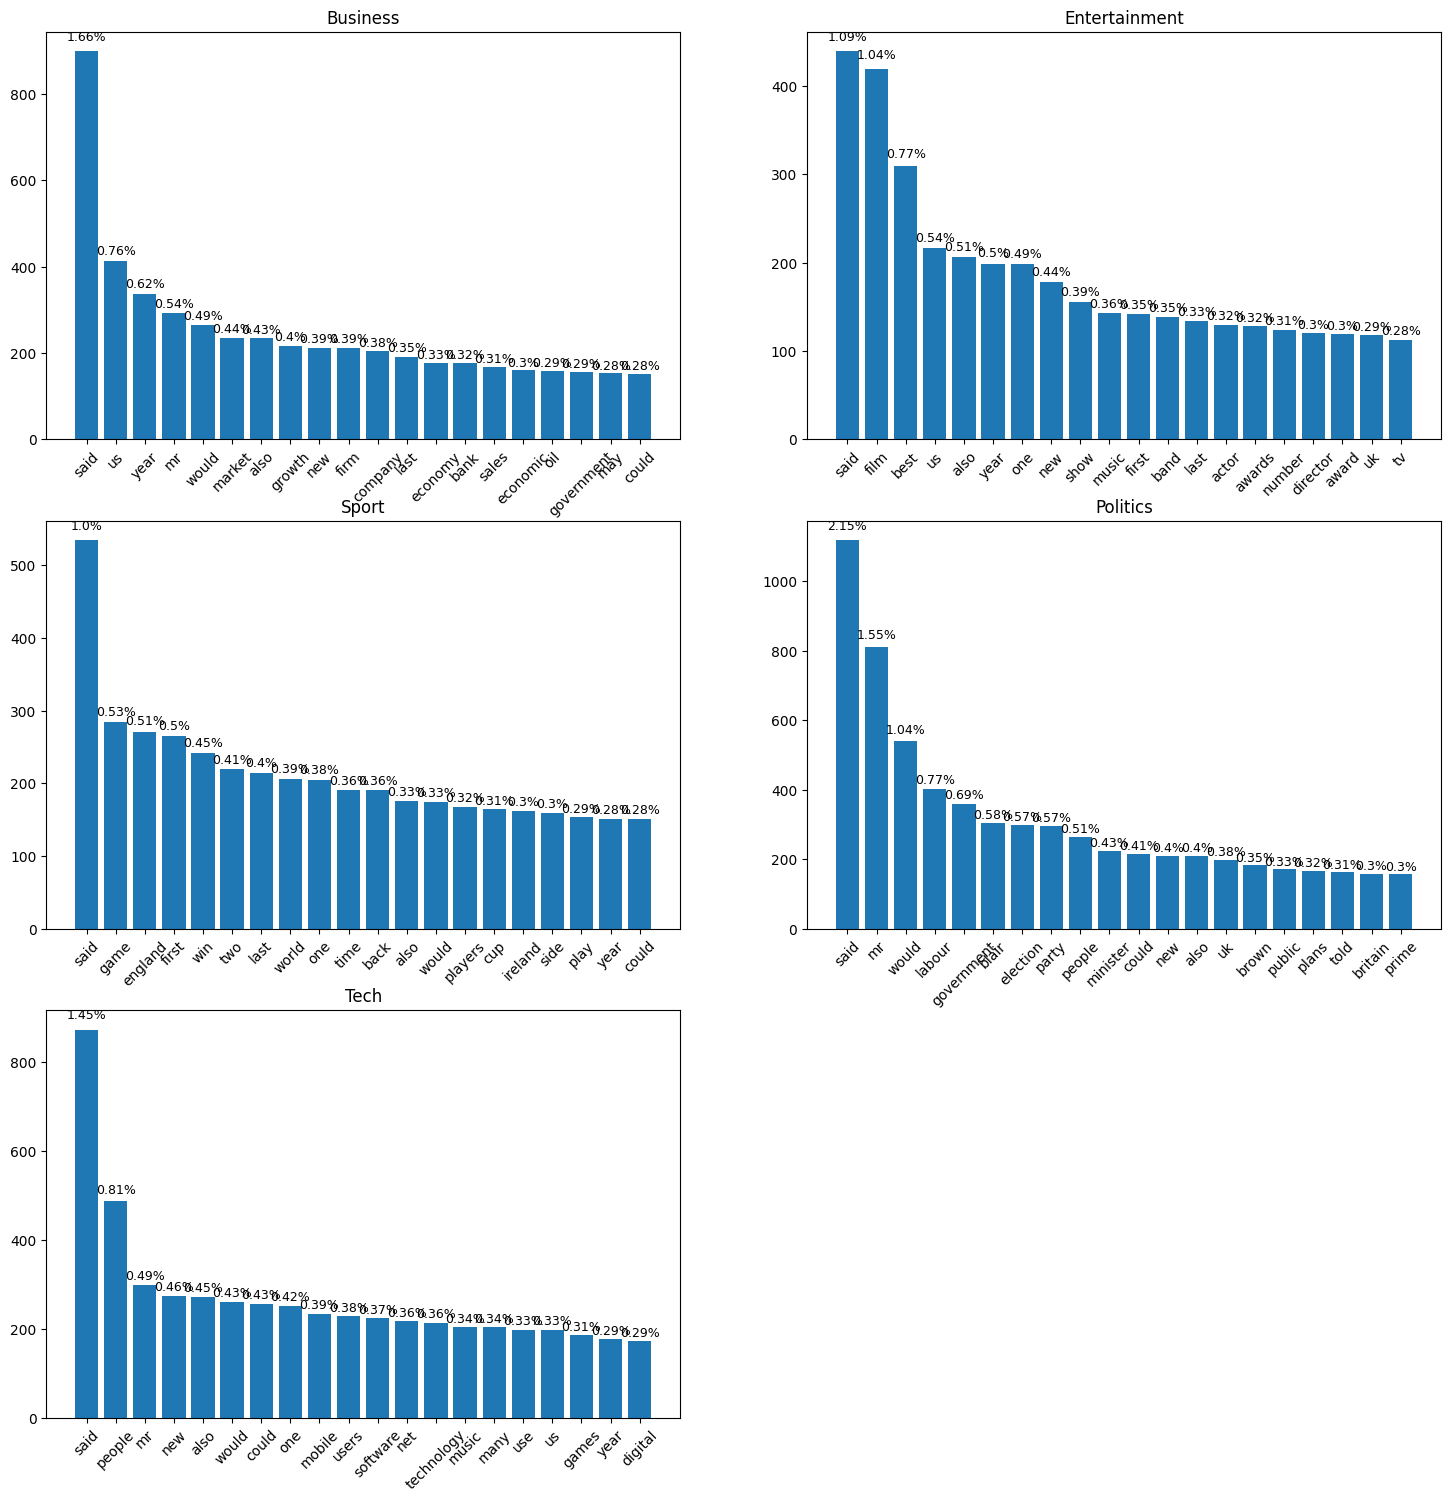

In [33]:
def create_graphs(diction,num_words): #class to dynamically plot bar graphs for word frequency by category
  diction_length = len(diction)
  for key in diction: #converting to series to use value_counts()
    diction[key] = pd.Series(diction[key])
  n_cols = int(math.sqrt(diction_length))
  n_rows = int(math.ceil(diction_length / n_cols))
  gs = gridspec.GridSpec(n_rows, n_cols) #creating dynamic grid 
  scale = max(n_cols, n_rows)
  fig = plt.figure(figsize=(6 * scale, 6 * scale))
  for i,key in zip(range(diction_length),diction.keys()): #plotting subplots
    ax = fig.add_subplot(gs[i])
    values = diction[key].value_counts().keys().tolist()[0:num_words]
    counts = diction[key].value_counts().tolist()[0:num_words]
    bar_chart = ax.bar(values, height = counts)
    ax = plt.gca()
    ax.tick_params(axis='x', labelrotation = 45)
    ax.set_title(key.capitalize())
    for bar in bar_chart: #adding each word frequency percentage  
      height = bar.get_height()
      ax.text(bar.get_x() + bar.get_width()/2., height*1.02, f"{round(100*int(height)/len(diction[key]),2)}%", ha='center', va='bottom', size =9)
create_graphs(dict1,20) # parameters are a dictionary and number of words per bar graph
# Note: text for word frequency percentage starts overlapping when num_words > 15

In the chart above the 15 most frequent words were graphed for each category in the training day. The word frequency distribution would allow a somone to easily extrapolate the associated categories. We will remove the word 'said' in the compact data preprocessing step because it is highly frequent and appears to provide little impact on providing context for the classification model.

In [34]:
train_eda['Number_of_Words_Updated'] = train_eda['Text'].apply(lambda x: len(x))

[Text(0.5, 1.0, 'Total Words Per Article')]

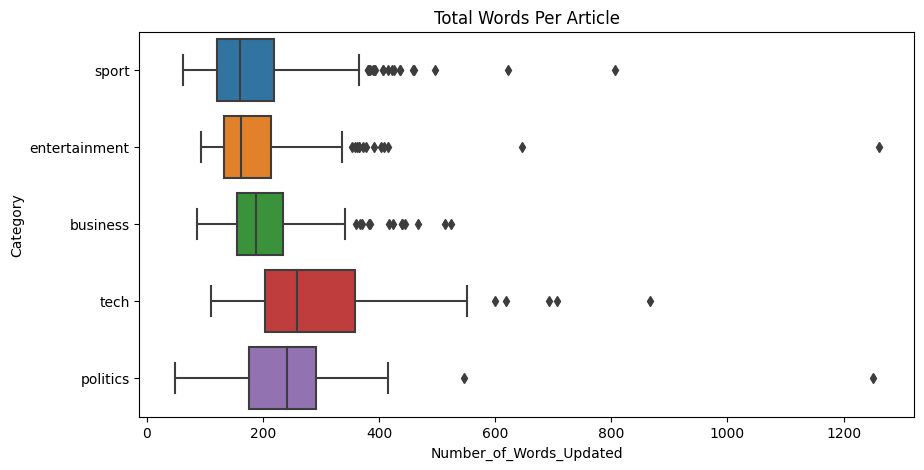

In [35]:
fig, ax = plt.subplots(figsize=(10, 5))
sns.boxplot(data = train_eda, x = 'Number_of_Words_Updated', y = 'Category').set(title = 'Total Words Per Article')

In the plot above we can see a few extreme outliers. They help explain the extended upper tails of the violin plots for 'entertainment' and 'politics'. We will not remove the outliers since the model will most likely be required to correctly classify articles with thousands of words in the future. 

### Condensed Preprocessing

In [36]:
print(stop_words)

{'them', 'its', "that'll", 'being', 'now', 'both', 'these', "you'll", "didn't", 'but', 'very', 'out', "aren't", 'at', 'on', 'am', "shouldn't", 'my', 'further', 'y', 'yours', 'm', 'wasn', 'me', 'between', 'that', 'he', 'himself', 'to', 'into', 'hadn', 'no', 'shan', 'few', 'then', 'is', 't', 'should', 'because', 'under', "needn't", 'through', "mightn't", 'she', 'most', 'wouldn', 'nor', 'needn', 'so', 'has', 'over', "you're", "she's", 'how', 'more', "couldn't", "you've", "weren't", 'an', 'until', 'have', 'be', 's', 'ain', 'myself', 'can', 'if', 'a', 'here', 'as', 'during', 'down', 'hers', 'ourselves', 'does', 'did', 'didn', 'own', 'couldn', 'too', "hadn't", "hasn't", 'who', 'above', 'him', 'such', 'in', 'yourself', 'will', 'your', 'where', "don't", 'while', 'themselves', 're', 'we', 'shouldn', 'they', "haven't", 'what', 'their', 'about', 'when', 'was', "mustn't", 'hasn', 'once', 'his', 'doesn', 'i', 'than', 'haven', 'other', "doesn't", "won't", "wasn't", 'won', 'been', 'the', 'theirs', 'd

In [37]:
def text_preprocessing(df,col_text):
  stop_words.add('said') #appending 'said' to stop_words list
  for i in range(len(df[col_text])):
    df[col_text][i] = word_tokenize(df[col_text][i]) #tokenizing
  for i in range(len(df)):
    df[col_text][i] = [word for word in df[col_text][i] if word not in string.punctuation] #removing punctuation 
  lemmatizer = WordNetLemmatizer()
  for i in range(len(df)):
    df[col_text][i] = [word for word in df[col_text][i] if word not in stop_words] #removing stopwords
  for i in range(len(df)):
    df[col_text][i] = [lemmatizer.lemmatize(word) for word in df[col_text][i]] #lemmatizing

  for i in range(len(df)):
    df[col_text][i] = ' '.join(df[col_text][i]) #rejoining words within each row to allow for vectorization 
  return df

In [38]:
train_eda

,ArticleId,Text,Category,Number_of_Words_Updated
0,290,"[sydney, host, north, v, south, game, sydney, ...",sport,164
1,1037,"[vera, drake, leads, uk, oscar, hopes, mike, l...",entertainment,296
2,500,"[argentina, closes, 102.6bn, debt, swap, argen...",business,178
3,458,"[podcasts, mark, rise, diy, radio, apple, ipod...",tech,551
4,175,"[mps, debate, euthanasia, laws, mps, preparing...",politics,337
...,...,...,...,...
1188,1229,"[savvy, searchers, fail, spot, ads, internet, ...",tech,284
1189,507,"[chelsea, clinch, cup, extra-time, extra-time,...",sport,393
1190,892,"[councils, must, find, gypsy, sites, ministers...",politics,295
1191,1039,"[apple, makes, blogs, reveal, sources, apple, ...",tech,231


# Modeling

There will be four separate modeling efforts.
1. No hyperparemter optimization or cross validation. 

2. Only hyperparameter optimization on the model.

3. hyperparameter optimization on the model and vectorizer. 

I would normally include a customized class that would allow for aspects of the text preprocessing to be validated such as choosing between stemming and lemmatizing. However, run time definitely became an issue so I was unable to do so. In the future I will hopefully be able to utilize stronger processors that will allow me to do this.

In [39]:
text_preprocessing(train_model, 'Text') #preprocessing train and test sets
text_preprocessing(test_set, 'Text')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/ipyk

,ArticleId,Text,Category
0,2093,u interest rate rise expected u interest rate ...,business
1,1060,mccririck big brother show racing pundit john ...,entertainment
2,1425,smith work scottish wonder worst kept secret s...,sport
3,1976,lifestyle governs mobile choice faster better ...,tech
4,1337,west end honour finest show west end honouring...,entertainment
...,...,...,...
291,1949,uk athletics agrees new kit deal uk athletics ...,sport
292,1690,brown shrug economy fear gordon brown freeze p...,politics
293,449,collins call chamber return world 100m champio...,sport
294,1012,making office work mission brighten working li...,business


### Model Attempt 1

In [40]:
x_train1 = train_model['Text'].values #initialing values for model attempt 1
y_train1 = train_model['Category'].values
x_test1 = test_set['Text'].values 
y_test1 = test_set['Category'].values
tfidf1 = TfidfVectorizer() 
x_train_vec1 = tfidf1.fit_transform(x_train1)
x_test_vec1 = tfidf1.transform(x_test1) 

In [41]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn import metrics
rf_clf1 = RandomForestClassifier()
rf_clf1.fit(x_train_vec1, y_train1)
predicted1 = rf_clf1.predict(x_test_vec1)
print(metrics.classification_report(y_test1, predicted1))

               precision    recall  f1-score   support

     business       0.97      0.92      0.95        66
entertainment       1.00      0.95      0.97        61
     politics       0.94      0.97      0.95        60
        sport       0.95      1.00      0.98        59
         tech       0.96      0.98      0.97        50

     accuracy                           0.96       296
    macro avg       0.96      0.96      0.96       296
 weighted avg       0.96      0.96      0.96       296



Here is the base random forest model without any hyperparameter tuning, cross validation, or pipeline and manually doing preprocessing and vectorizing. I would not reccommend deploying a model this way because it will not generalize well.

### Model Attempt 2

In [42]:
x_train2 = train_model['Text'].values #initialing values for model attempt 2
y_train2 = train_model['Category'].values
x_test2 = test_set['Text'].values 
y_test2 = test_set['Category'].values
tfidf2 = TfidfVectorizer() 
x_train_vec2 = tfidf2.fit_transform(x_train2)
x_test_vec2 = tfidf2.transform(x_test2) 

In [43]:
from sklearn.model_selection import RandomizedSearchCV
n_estimators2 = [x for x in range(100,301,50)] #initializing possible hyperparamater values for grid 
max_features2 = ['sqrt']
max_depth2 = [x for x in range(5,35,10)]
min_samples_split2 = [2,4,6,8, 10]
min_samples_leaf2 = [1, 2, 5]
bootstrap2 = [True]
# Creating the random grid
random_grid = {'n_estimators': n_estimators2,
               'max_features': max_features2,
               'max_depth': max_depth2,
               'min_samples_split': min_samples_split2,
               'min_samples_leaf': min_samples_leaf2,
               'bootstrap': bootstrap2}
# 6*1*6*5*3*1 = 900 possible values

In [44]:
rf2 = RandomForestClassifier()
# Random search of parameters, using 3 fold cross validation, searching across 100 different combinations, and using all available cores
rf_random2 = RandomizedSearchCV(estimator = rf2, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=-1, random_state=99, n_jobs = -1)
# Fit the random search model
result2 = rf_random2.fit(x_train_vec2, y_train2)

In [69]:
cv_results2 = pd.DataFrame.from_dict(result2.cv_results_)
cv_results2.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_estimators,param_min_samples_split,param_min_samples_leaf,param_max_features,param_max_depth,param_bootstrap,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,1.096701,0.007746,0.179513,0.014778,300,8,2,sqrt,5,True,"{'n_estimators': 300, 'min_samples_split': 8, ...",0.871859,0.886935,0.906801,0.888532,0.014310,80
1,1.279118,0.032065,0.090894,0.002333,150,6,2,sqrt,25,True,"{'n_estimators': 150, 'min_samples_split': 6, ...",0.962312,0.967337,0.937028,0.955559,0.013263,4
2,1.403134,0.028061,0.119254,0.000991,200,2,2,sqrt,15,True,"{'n_estimators': 200, 'min_samples_split': 2, ...",0.954774,0.949749,0.937028,0.947183,0.007468,41
3,0.893742,0.010113,0.138466,0.002017,250,6,5,sqrt,5,True,"{'n_estimators': 250, 'min_samples_split': 6, ...",0.876884,0.889447,0.889169,0.885167,0.005858,89
4,0.847948,0.008838,0.087189,0.001656,150,6,5,sqrt,15,True,"{'n_estimators': 150, 'min_samples_split': 6, ...",0.957286,0.954774,0.944584,0.952215,0.005492,19


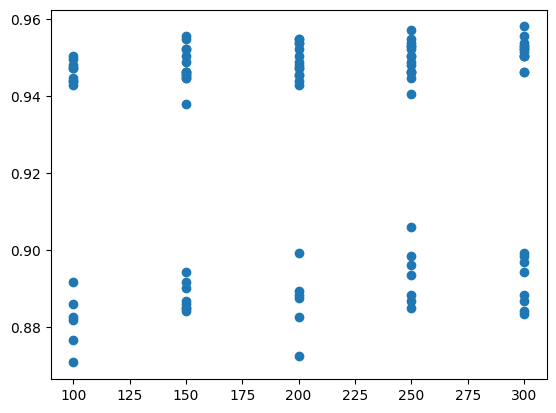

In [47]:
plt.plot(cv_results2['param_n_estimators'], cv_results2['mean_test_score'], 'o' ) 

There are two noticebable clusters, we should inspect performance of the other paramaters to determine the cause of this noticeable gap. Also the model appears to perfrom better the higher the number of estimators. 

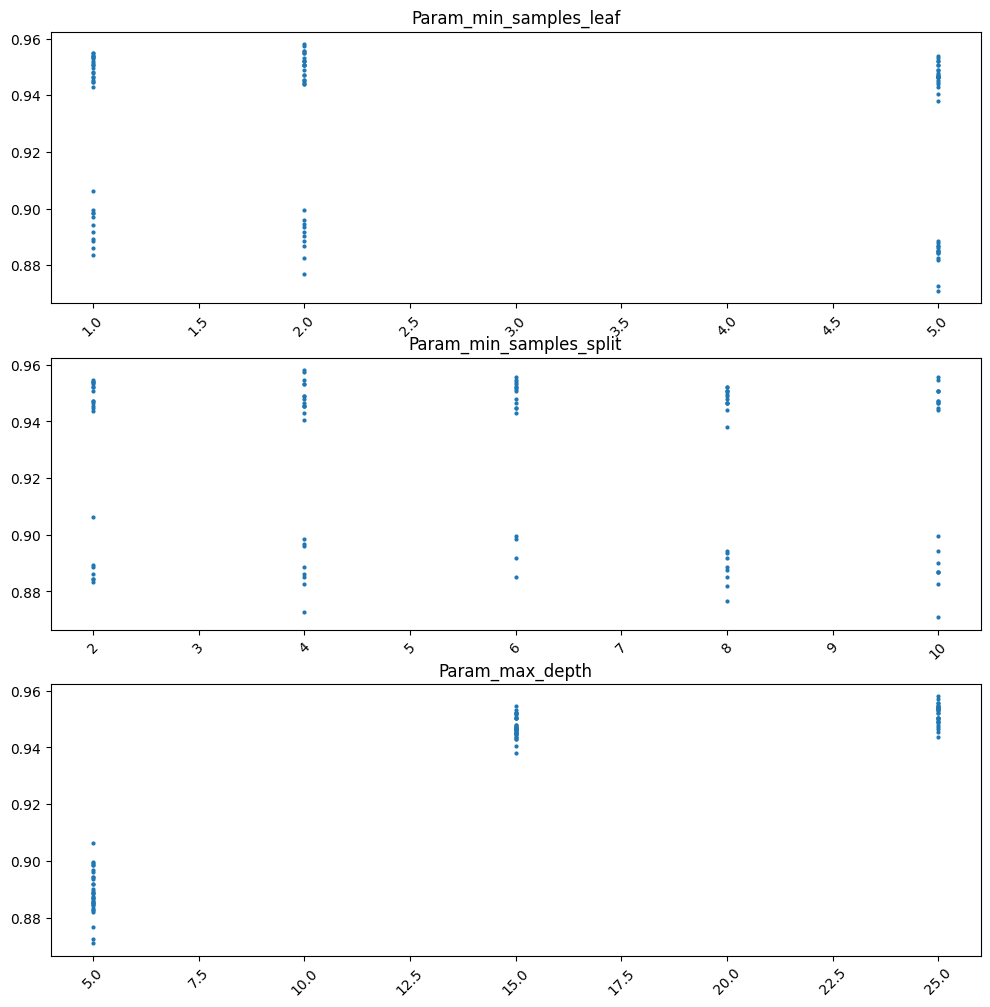

In [63]:
def performance_graphs(results_df, params_list,scoring_metric):
  num_params = len(params_list)
  # for val in diction: #converting to series to use value_counts()
  #   diction[key] = pd.Series(diction[key])
  n_cols = int(math.sqrt(num_params))
  n_rows = int(math.ceil(num_params / n_cols))
  gs = gridspec.GridSpec(n_rows, n_cols) #creating dynamic grid 
  scale = max(n_cols, n_rows)
  fig = plt.figure(figsize=(4 * scale, 4 * scale))
  for i, param in zip(range(num_params),params_list): #plotting subplots
    ax = fig.add_subplot(gs[i])
    scatter_plot = ax.scatter(results_df[param], results_df[scoring_metric],s = 4)
    ax.tick_params(axis='x', labelrotation = 45)
    ax.set_title(param.capitalize())
  plt.show()
performance_graphs(cv_results2,['param_min_samples_leaf', 'param_min_samples_split','param_max_depth' ], 'mean_test_score')


From the graph a higher depth results in a higher score. We need to be careful to overfit our data so in our next instance of randomizedsearchcv we will make the max_depth at least 15. Also, the min_samples_leaf paramater performs poorly when it is at 5, so we will make the next instance of the paramater be 1,2, or 3. Due to min min_samples_leaf already beign assigned, min_sample_split appears to have little affect on the model.

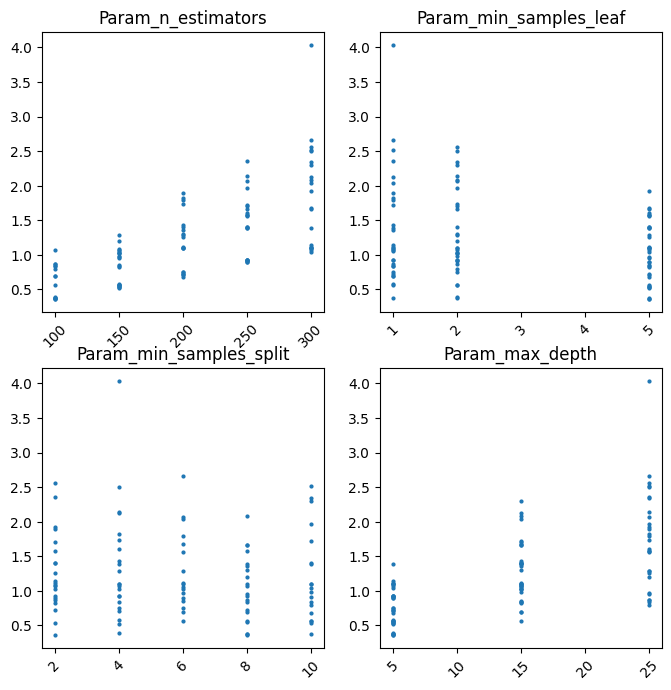

In [71]:
performance_graphs(cv_results2,['param_n_estimators','param_min_samples_leaf', 'param_min_samples_split','param_max_depth'], 'mean_fit_time')

To help understand the tradeoff betweem runtime and model complexity, we created graphs showing the runtime at different values for each of the hyperparameters. As can be seen from the graphs above runtime for fitting the model has a tendency to increase when max_depth or n_estimators increase.

In [49]:
print(f'Best Score: {result2.best_score_}')
print(f'Best Hyperparameters: {result2.best_params_}')

Best Score: 0.958083870232776
Best Hyperparameters: {'n_estimators': 300, 'min_samples_split': 4, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'max_depth': 25, 'bootstrap': True}


We can see that our model perfroms very well here. However it should be noted that the model won't generalize as well when not doing a nested cross validation. We should to the vectorizing and modeling cross validation steps together to minimize data leakage. 

### Model Attempt 3

This is generally poor practice, but I will be using some of the results from the randomsearch on the second model to help select ranges for the third model's randomized search

In [50]:
rf_pipeline3 = Pipeline([
 ('vectorizer', TfidfVectorizer()),
 ('model', RandomForestClassifier())
])

**Randomized Search for best parameters**

In [51]:
x_train3 = train_model['Text'].values 
y_train3 = train_model['Category'].values
x_test3 = test_set['Text'].values 
y_test3 = test_set['Category'].values

In [100]:
n_estimators3 = [x for x in range(275,326,10)] #max of 325 due to runtime issues after exceed this amount
max_features3 = ['sqrt']
max_depth3 = [x for x in range(15,56,10)]
min_samples_split3 = [3,4,6,8] #chose over min_samples leaf to improve runtime
bootstrap3 = [True]
n_grams = [(1, 1), (1, 2), (2, 2)]
params_tfrf3 = {
 'vectorizer__ngram_range':n_grams, 
 'vectorizer__stop_words': ['english'],
 'model__n_estimators': n_estimators3,
               'model__max_features': max_features3,
               'model__max_depth': max_depth3,
               'model__min_samples_split': min_samples_split3,
               'model__bootstrap': bootstrap3}
start = time.time()
rf_search3 = RandomizedSearchCV(rf_pipeline3, param_distributions =params_tfrf3,  n_iter = 100 , cv = 3, verbose =-1, n_jobs = -1, random_state = 99)
rf_result3 = rf_search3.fit(x_train3,y_train3)
print(f"total time to compute: {start - time.time()}")
print(f'Best Score: {rf_result3.best_score_}')
print(f'Best Hyperparameters: {rf_result3.best_params_}')

total time to compute: -327.45588970184326
Best Score: 0.9631111054854458
Best Hyperparameters: {'vectorizer__stop_words': 'english', 'vectorizer__ngram_range': (1, 1), 'model__n_estimators': 305, 'model__min_samples_split': 4, 'model__max_features': 'sqrt', 'model__max_depth': 35, 'model__bootstrap': True}


In [101]:
rcv_results3 = pd.DataFrame.from_dict(rf_result3.cv_results_)

In [104]:
rcv_results3.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_vectorizer__stop_words,param_vectorizer__ngram_range,param_model__n_estimators,param_model__min_samples_split,param_model__max_features,param_model__max_depth,param_model__bootstrap,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,2.736515,0.017024,0.294778,0.004440,english,"(1, 1)",305,4,sqrt,55,True,"{'vectorizer__stop_words': 'english', 'vectori...",0.952261,0.962312,0.952141,0.955571,0.004766,12
1,2.858776,0.023515,0.299066,0.006694,english,"(1, 1)",325,4,sqrt,55,True,"{'vectorizer__stop_words': 'english', 'vectori...",0.957286,0.957286,0.942065,0.952213,0.007175,26
2,2.587877,0.017315,0.290484,0.008191,english,"(1, 1)",325,6,sqrt,35,True,"{'vectorizer__stop_words': 'english', 'vectori...",0.959799,0.959799,0.952141,0.957246,0.003610,7
3,2.488740,0.007787,0.286339,0.014123,english,"(1, 1)",305,8,sqrt,45,True,"{'vectorizer__stop_words': 'english', 'vectori...",0.957286,0.949749,0.949622,0.952219,0.003584,22
4,4.069947,0.019280,0.545006,0.048887,english,"(1, 2)",295,3,sqrt,15,True,"{'vectorizer__stop_words': 'english', 'vectori...",0.924623,0.932161,0.929471,0.928752,0.003119,66


In [105]:
rcv_results3['param_vectorizer__ngram_range'] = rcv_results3['param_vectorizer__ngram_range'].astype(str)

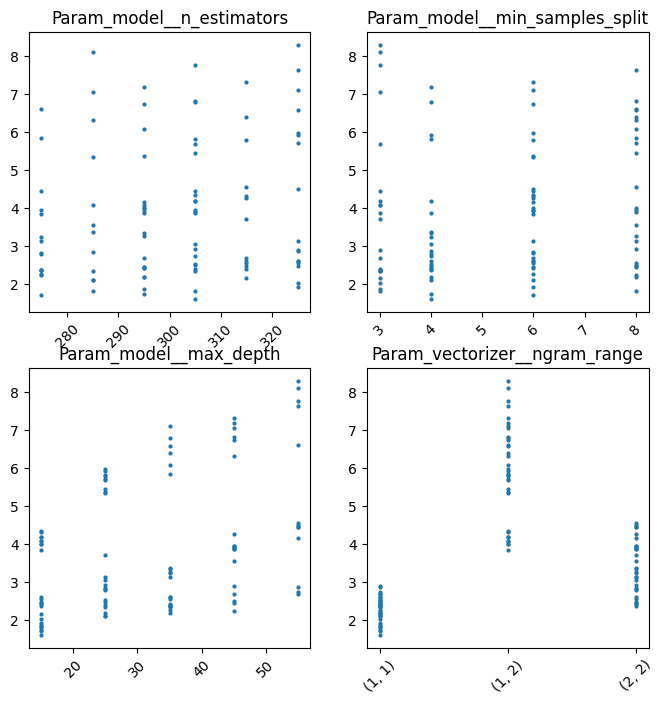

In [106]:
performance_graphs(rcv_results3,['param_model__n_estimators','param_model__min_samples_split','param_model__max_depth', 'param_vectorizer__ngram_range'], 'mean_fit_time') #iteratively checking runtime to make adjustments to hyperparameter search grid

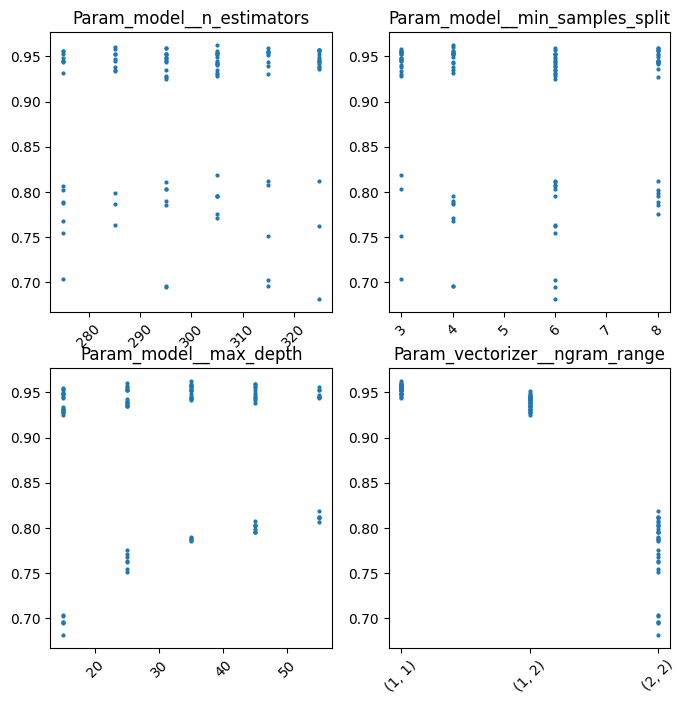

In [107]:
performance_graphs(rcv_results3,['param_model__n_estimators','param_model__min_samples_split','param_model__max_depth', 'param_vectorizer__ngram_range'], 'mean_test_score')

Unigrams (single words) performed the best runtime and accuracy wise. There were many iterations done beyond what is shown in the notebook to help locate  the point where runtimes began increasing more exponentially for different hyperparameters.

**GridSearch**

Based on best paramaters from randomizedsearch

In [111]:
x_train_gs = train_model['Text'].values #initializing values for gridsearch
y_train_gs = train_model['Category'].values
x_test_gs = test_set['Text'].values 
y_test_gs = test_set['Category'].values

In [112]:
from sklearn.model_selection import GridSearchCV
rf_pipeline_gs = Pipeline([
 ('vectorizer', TfidfVectorizer()),
 ('model', RandomForestClassifier())
])
params_gs =  {'vectorizer__stop_words': ['english'], 
 'vectorizer__ngram_range': [(1, 1)], 'model__n_estimators': [x for x in range(275,326,10)], 
 'model__min_samples_split': [3,4,6,8] ,  'model__max_features': ['sqrt'], 
 'model__max_depth': [x for x in range(15,56,10)], 
 'model__bootstrap': [True]}
gs = GridSearchCV(rf_pipeline_gs, param_grid= params_gs, cv =3, n_jobs = -1)
#runtime should be slightly faster since only using unigrams (even after accountbing for 120 iterations)

In [113]:
result_gs = gs.fit(x_train_gs,y_train_gs)

In [114]:
print(f'Best Score: {result_gs.best_score_}')
print(f'Best Hyperparameters: {result_gs.best_params_}')

Best Score: 0.9622778037964803
Best Hyperparameters: {'model__bootstrap': True, 'model__max_depth': 55, 'model__max_features': 'sqrt', 'model__min_samples_split': 6, 'model__n_estimators': 295, 'vectorizer__ngram_range': (1, 1), 'vectorizer__stop_words': 'english'}


In [115]:
gscv_results3 = pd.DataFrame.from_dict(result_gs.cv_results_)

In [116]:
gscv_results3['param_vectorizer__ngram_range'] = gscv_results3['param_vectorizer__ngram_range'].astype(str)

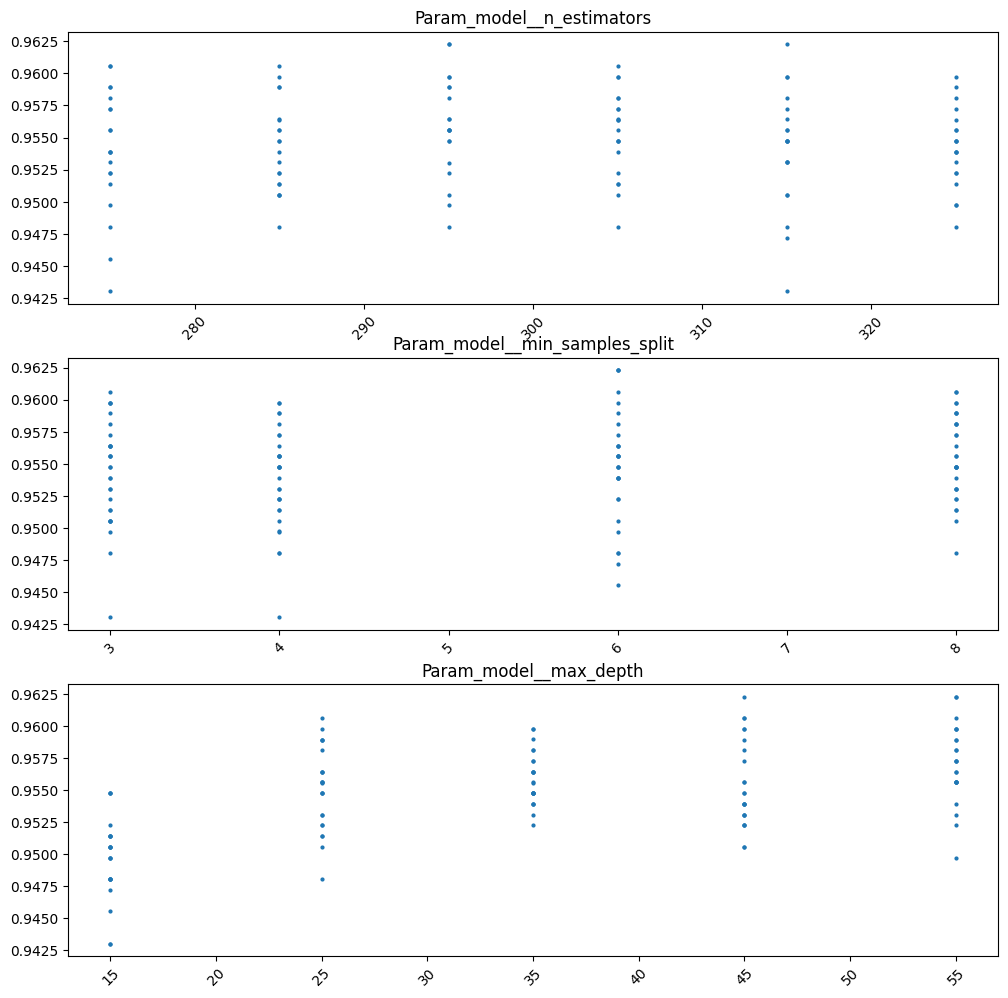

In [119]:
performance_graphs(gscv_results3,['param_model__n_estimators','param_model__min_samples_split','param_model__max_depth'], 'mean_test_score')

In [125]:
from statistics import median
eval_parms_lst = ['param_model__n_estimators','param_model__min_samples_split','param_model__max_depth']
for val in eval_parms_lst:
  print(gscv_results3.groupby(val)['mean_test_score'].median())

param_model__n_estimators
275    0.953893
285    0.954313
295    0.955573
305    0.955988
315    0.954734
325    0.954312
Name: mean_test_score, dtype: float64
param_model__min_samples_split
3    0.954731
4    0.954732
6    0.955150
8    0.955151
Name: mean_test_score, dtype: float64
param_model__max_depth
15    0.950120
25    0.955565
35    0.955567
45    0.954313
55    0.957242
Name: mean_test_score, dtype: float64


The different values within each paramater have very similar medians for accuracy score so we will use the best model. 

**Running Best Performing Model on Test Data**

In [120]:
x_train_last = train_model['Text'].values #initializing values for gridsearch
y_train_last = train_model['Category'].values
x_test_last = test_set['Text'].values 
y_test_last = test_set['Category'].values

In [126]:
rf_pipeline_final = Pipeline([
 ('vectorizer', TfidfVectorizer(stop_words = 'english', ngram_range = (1, 1))), #hyperparamaters were hard coded 
 ('model', RandomForestClassifier(n_estimators=295, min_samples_leaf=2, min_samples_split=6, max_depth=55, bootstrap= True, max_features= 'sqrt' )) 
])

In [127]:
rf_pipeline_final.fit(x_train_last,y_train_last)
final_predictions = rf_pipeline_final.predict(x_test_last)
accuracy_score(final_predictions, y_test_last)

0.956081081081081

Extra hold out set was used to check generalizability of model.

**Comparing result to commonly used supervised learning algorithms:**
- K-Nearest Neighbors 
- Nu Support Vector Classicatoin (variation of Support Vector Classifier that controls for number of support vectors)
- Decision Tree Classifier
- Random Forest Classifier (Decision Tree + bagging)
- Extreme Gradient Boosting Classifier (Decision Tree + boosting)

Note: I did not tune any of the models below due to time constraints. 

In [137]:
from sklearn.metrics import accuracy_score, log_loss
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import NuSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
x_train_all = train_model['Text'].values 
y_train_all = train_model['Category'].values
x_test_all = test_set['Text'].values 
y_test_all = test_set['Category'].values
classifiers = [
    KNeighborsClassifier(5),
    NuSVC(probability=True),
    DecisionTreeClassifier(),
    RandomForestClassifier(), 
    XGBClassifier()
    ]
for classifier in classifiers:
    pipe = Pipeline(steps=[('preprocessor', TfidfVectorizer()),
                      ('classifier', classifier)])
    pipe.fit(x_train_all, y_train_all)   
    print(f"\033[1m{classifier}\033[0m")
    score = pipe.score(x_test_all, y_test_all)
    print(f" accruarcy: {score} ")

KNeighborsClassifier()
 accruarcy: 0.9054054054054054 
NuSVC(probability=True)
 accruarcy: 0.9662162162162162 
DecisionTreeClassifier()
 accruarcy: 0.8344594594594594 
RandomForestClassifier()
 accruarcy: 0.9628378378378378 
XGBClassifier(objective='multi:softprob')
 accruarcy: 0.9391891891891891 


With most iterations the Random Forest Classfier directly above appears to perform better without any tuning (done in model 3).  
The top two performers were Nu Support Vector Classication and the Random Forest Classifier. 



## Evaluation

In [129]:
print(submission_data.columns)

Index(['ArticleId', 'Text'], dtype='object')


In [130]:
x_test_sub = submission_data['Text'].values

In [138]:
submission_pred = rf_pipeline_final.predict(x_test_sub)

In [139]:
submission = pd.DataFrame(list(zip(submission_data['ArticleId'], submission_pred)),
               columns =['ArticleId', 'Category'])
submission.head(20)

,ArticleId,Category
0,1018,sport
1,1319,tech
2,1138,sport
3,459,business
4,1020,sport
5,51,sport
6,2025,politics
7,1479,politics
8,27,entertainment
9,397,business


In [140]:
submission.to_csv('submission.csv', index=False)

After submitting to Kaggle, my score was .96462 (based on accuracy). This was actually better than the top score when running the best model on the training data. This is likely due to the cross validation techinque generalizing very well. 

## Conclusion

To improve submission accuracy significantly further, utlizing deep learning techniques will become necessary. The alternative would be an expansive gridsearch or halving gridsearch including all of the data preprocessing steps as well as a more exhaustive preprocessing approach. However, this may lead to overfitting. I chose the TFIDF vectorizer and random forest classifier because of it's interpretability. Other techniques may be used for improved or similar performance. It is also important to mention that this was my first time working with Natural Language Processing and pipelines. As a result, there will be inefficienies within my code that lead to poorer performance. Explanations of many of the core concepts are in a separate notebook on GitHub labeled as "prerequisite knowledge". Many of the resources I used to learn more about NLP are in that notebook as well. I should also mention **I did not have any assiatance throughout the duration of this project and would love any feedback.** 